# Plot Correlation

* [seaborn.pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html)
* [pandas.DataFrame.corr](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html)

In [36]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    KBinsDiscretizer
)
from sklearn.impute import (
    SimpleImputer
)
from sklearn.compose import (
    ColumnTransformer
)
from sklearn.pipeline import (
    Pipeline
)
from sklearn.ensemble import (
    RandomForestClassifier
)
from sklearn.svm import (
    LinearSVC
)
from sklearn.metrics import (
    accuracy_score
)

# Constant

In [2]:
DATA_DIR: str = "../data/titanic"

# Dataframe

In [3]:
drop_columns = ["PassengerId", "Name", "Ticket", "Cabin"]

In [4]:
df = pd.read_csv(
    f"{DATA_DIR}/train.csv"
)
df.drop(labels=drop_columns, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [5]:
df.columns.tolist()

['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [6]:
df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S


# Unique Values

In [7]:
sorted(df["Pclass"][df["Pclass"].notna()].unique())

[1, 2, 3]

In [8]:
sorted(df["Embarked"][df["Embarked"].notna()].unique())

['C', 'Q', 'S']

In [9]:
sorted(df["SibSp"][df["SibSp"].notna()].unique())

[0, 1, 2, 3, 4, 5, 8]

array([[<Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>],
       [<Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Fare'}>]], dtype=object)

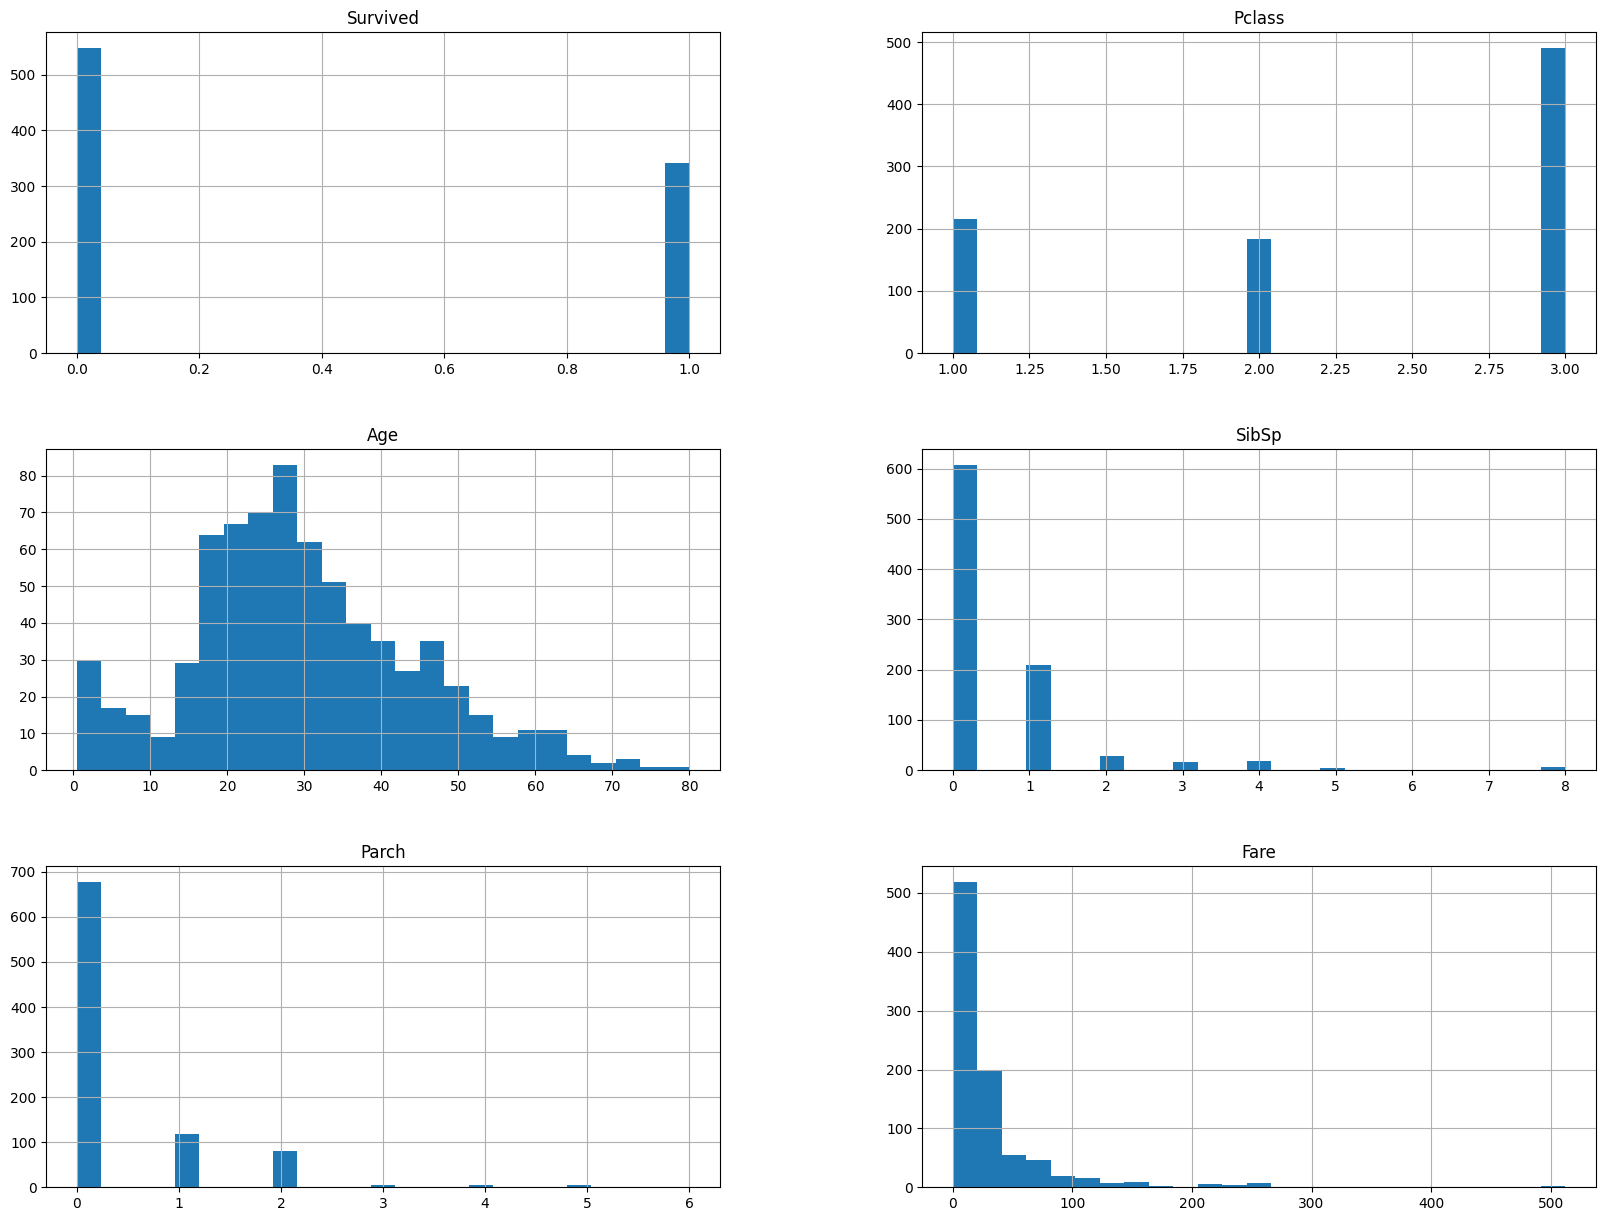

In [10]:
df.hist(bins=25, figsize=(20, 15))

# NaN Columns

In [11]:
x = df.isna().any(axis=0)
x.loc[(x == True)]

Age         True
Embarked    True
dtype: bool

## Age

In [12]:
df["Age"].isnull().sum()

177

In [13]:
df.loc[(df["Age"].isnull() | (df["Age"] < 0) | (df["Age"] > 100))].head()
# df.loc[(df["Age"].isnull() | (df["Age"] < 0) | (df["Age"] > 100)), "Age"] = 0

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
5,0,3,male,NaN,0,0,8.4583,Q
17,1,2,male,NaN,0,0,13.0000,S
19,1,3,female,NaN,0,0,7.2250,C
26,0,3,male,NaN,0,0,7.2250,C
28,1,3,female,NaN,0,0,7.8792,Q


## Embarked

In [14]:
df[df["Embarked"].isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
61,1,1,female,38.0,0,0,80.0,NaN
829,1,1,female,62.0,0,0,80.0,NaN


# Feature Engineering


In [15]:
Y_train = df["Survived"]
df_train = df.drop("Survived", axis=1)
df_train.head(3)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S


## Numerical Columns

In [16]:
numerical_binning_columns = ['Age', 'Fare']

In [26]:
numerical_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="mean")),
    ("bin", KBinsDiscretizer(n_bins=5, encode="onehot"))
])

## Categorical Columns

In [27]:
categorical_columns = ['Pclass', 'SibSp', 'Sex', 'Parch', 'Embarked']

In [28]:
categorical_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("encode", OneHotEncoder(handle_unknown="ignore"))
])

## Execute

In [29]:
feature_engineering_pipeline = ColumnTransformer([
    ("numerical", numerical_pipeline, numerical_binning_columns),
    ("categorical", categorical_pipeline, categorical_columns)
])

In [30]:
X_train = feature_engineering_pipeline.fit_transform(df_train)

---
# Model Training (SVM)

In [31]:
classifier = LinearSVC()

In [38]:
classifier.fit(X_train, Y_train)

LinearSVC()

## Model accuracy on training


In [40]:
accuracy_score(y_true=Y_train, y_pred=classifier.predict(X_train))

0.8058361391694725

# Test

In [33]:
df_test = pd.read_csv(f"{DATA_DIR}/test.csv").drop(drop_columns, axis=1)
df_test.head(3)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q


In [34]:
X_test = feature_engineering_pipeline.transform(df_test)

In [35]:
classifier.predict(X_test)

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,